In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
fuel_economy_csv = 'C:/users/rickk/Documents/DataScience/GeneralAssembly/Final_Project/dataset/database.csv'
fuel_economy = pd.read_csv(fuel_economy_csv, dtype={'Transmission Descriptor': str,
                                                   'Fuel Type 2': str,
                                                   'Start Stop Technology': str,
                                                   'Electric Motor': str,
                                                   'Manufacturer Code': str,
                                                   'Vehicle Charger': str,
                                                   'Alternate Charger': str,
                                                   'Range (FT2)': str}).fillna(0)
# reading in data produced error message for mixed types columns (7,16,62,64,65,67,68,78) - explored with .iloc[:,col]
# column iloc[78] Range (FT2) has ranges and sometimes several values at the same time included
# need to split or define new column with middle value of ranges given in that column iloc[78] if I use it
# filling all NaN with zero values

In [3]:
print (fuel_economy.shape)

(38113, 81)


The data set has a lot of columns that capture MPG and CO2 information for different vehicles, obtained in tests for *city*, *highway* and *combined*. Not all of the columns are required. The **target variable(s)** I wanted to pursue are 'Tailpipe CO2 (FT1)' and 'Tailpipe CO2 (FT2)' - which need to be combined to **Total Tailpipe CO2**. I was specifically interested in the share of CO2 that can be attributed to city traffic vs. high-way traffic for a particular time-period, but the dictionary shows that "year" refers to the car model's year of issue (i.e. vintage of the car) and **not** the year of measuring the data. My misunderstanding.

Given my misunderstanding about time series, I suggest to explore the following elements going forward:
1. Target variable(s): Annual Fuel Cost (FT1) and (FT2); and TailPipe CO2 (FT1) and (FT2)
    <br> Note: the EPA calculates annual fuel cost based on 15,000 miles driving, thereof 55% city and the price of fuel used by the vehicle
2. Build a predictive model for Annual Fuel Cost and CO2 emissions
3. Assumptions: **driving patterns** mix of *city*, *highway*, aka ***combined*** driving
4. Features to use predicting Annual Fuel Cost and CO2 emissions: year build (vintage) and other car-characteristics (MPG, passenger/loading volume (in cubic ft, if useful?), start/stop and engine technology) - based on results of EDA - need to select and narrow down, probably need to turn a few categorical into numerical variables etc.
<br>
<br> More information available at: https://www.fueleconomy.gov/feg/ws/index.shtml#ft2

In [4]:
fuel_economy.columns

Index(['Vehicle ID', 'Year', 'Make', 'Model', 'Class', 'Drive', 'Transmission',
       'Transmission Descriptor', 'Engine Index', 'Engine Descriptor',
       'Engine Cylinders', 'Engine Displacement', 'Turbocharger',
       'Supercharger', 'Fuel Type', 'Fuel Type 1', 'Fuel Type 2',
       'City MPG (FT1)', 'Unrounded City MPG (FT1)', 'City MPG (FT2)',
       'Unrounded City MPG (FT2)', 'City Gasoline Consumption (CD)',
       'City Electricity Consumption', 'City Utility Factor',
       'Highway MPG (FT1)', 'Unrounded Highway MPG (FT1)', 'Highway MPG (FT2)',
       'Unrounded Highway MPG (FT2)', 'Highway Gasoline Consumption (CD)',
       'Highway Electricity Consumption', 'Highway Utility Factor',
       'Unadjusted City MPG (FT1)', 'Unadjusted Highway MPG (FT1)',
       'Unadjusted City MPG (FT2)', 'Unadjusted Highway MPG (FT2)',
       'Combined MPG (FT1)', 'Unrounded Combined MPG (FT1)',
       'Combined MPG (FT2)', 'Unrounded Combined MPG (FT2)',
       'Combined Electricity Consu

In [5]:
# look at each column with count_values to see how much data is in there and what kind it is
fuel_economy.loc[:,'Range (FT2)'].value_counts()

0              36680
290               74
270               56
280               53
310               41
277               38
260               35
307               33
320               28
300               28
280/380           26
240               24
308               24
329               22
413               22
338               20
304               19
269               19
340               18
295               16
279               16
273               15
310/390           14
296               14
290/410           14
280-350           14
330               13
262               13
353               13
14                13
               ...  
180                1
250/370            1
264/380            1
36                 1
334                1
230/270            1
328                1
240-420            1
22                 1
303                1
256                1
220/270/260        1
25                 1
230/270/270        1
17                 1
240/290/280        1
97           

In [6]:
# renaming columns to make data easier to handle
fuel_economy = fuel_economy.rename(columns = {'Vehicle ID': 'ID', 'Year': 'vintage', 'Make': 'make', 'Model': 'model',
                                              'Class': 'class', 'Drive': 'wheel_drive', 'Transmission': 'transm',
                                              'Transmission Descriptor': 'transm_descr', 'Engine Index': 'engine_ind',
                                              'Engine Descriptor': 'engine_descr', 'Engine Cylinders': 'num_cylinder',
                                              'Engine Displacement': 'engine_displace', 'Turbocharger': 'turbo', 'Supercharger': 'super',
                                              'Fuel Type': 'FT', 'Fuel Type 1': 'FT1', 'Fuel Type 2': 'FT2', 'City MPG (FT1)': 'city_mpg_1',
                                              'Unrounded City MPG (FT1)': 'city_mpg_1_exact', 'City MPG (FT2)': 'city_mpg_2',
                                              'Unrounded City MPG (FT2)': 'city_mpg_2_exact', 'City Gasoline Consumption (CD)': 'city_gas_cons',
                                              'City Electricity Consumption': 'city_e_cons', 'City Utility Factor': 'city_utility',
                                              'Highway MPG (FT1)': 'hw_mpg_1', 'Unrounded Highway MPG (FT1)': 'hw_mpg_1_exact',
                                              'Highway MPG (FT2)': 'hw_mpg_2', 'Unrounded Highway MPG (FT2)': 'hw_mpg_2_exact',
                                              'Highway Gasoline Consumption (CD)': 'hw_gas_cons', 
                                              'Highway Electricity Consumption': 'hw_e_cons', 'Highway Utility Factor': 'hw_utility',
                                              'Unadjusted City MPG (FT1)': 'city_mpg_1_unadj',
                                              'Unadjusted Highway MPG (FT1)': 'hw_mpg_1_unadj',
                                              'Unadjusted City MPG (FT2)': 'city_mpg_2_unadj',
                                              'Unadjusted Highway MPG (FT2)': 'hw_mpg_2_unadj',
                                              'Combined MPG (FT1)':'combi_mpg_1', 'Unrounded Combined MPG (FT1)': 'combi_mpg_1_exact',
                                              'Combined MPG (FT2)': 'combi_mpg_2', 'Unrounded Combined MPG (FT2)': 'combi_mpg_2_exact',
                                              'Combined Electricity Consumption': 'combi_e_cons',
                                              'Combined Gasoline Consumption (CD)': 'combi_gas_cons', 'Combined Utility Factor': 'combi_utility',
                                              'Annual Fuel Cost (FT1)': 'cost_1', 'Annual Fuel Cost (FT2)': 'cost_2',
                                              'Gas Guzzler Tax': 'guzzler_tax', 'Save or Spend (5 Year)': 'save_or_spend',
                                              'Annual Consumption in Barrels (FT1)': 'barrels_1', 'Annual Consumption in Barrels (FT2)': 'barrels_2',
                                              'Tailpipe CO2 (FT1)': 'co2_1', 'Tailpipe CO2 in Grams/Mile (FT1)': 'co2_gm_1',
                                              'Tailpipe CO2 (FT2)': 'co2_2', 'Tailpipe CO2 in Grams/Mile (FT2)': 'co2_gm_2',
                                              'Fuel Economy Score': 'fuel_eco_score', 'GHG Score': 'ghg_score',
                                              'GHG Score (Alt Fuel)': 'ghg_score_alt', 'My MPG Data': 'my_mpg',
                                              '2D Passenger Volume': '2D_pass_vol', '2D Luggage Volume': '2D_lugg_vol',
                                              '4D Passenger Volume': '4D_pass_vol', '4D Luggage Volume': '4D_lugg_vol',
                                              'Hatchback Passenger Volume': 'hatchb_pass_vol', 'Hatchback Luggage Volume': 'hatchb_lugg_vol',
                                              'Start Stop Technology': 'start_stop', 'Alternative Fuel/Technology': 'alt_fuel',
                                              'Electric Motor': 'e_motor', 'Manufacturer Code': 'manuf_code',
                                              'Gasoline/Electricity Blended (CD)': 'g_e_blend', 'Vehicle Charger': 'charger',
                                              'Alternate Charger': 'charger_alt', 'Hours to Charge (120V)':'charge_hr_120V',
                                              'Hours to Charge (240V)': 'charge_hr_240V','Hours to Charge (AC 240V)': 'charge_hr_240V_AC',
                                              'Composite City MPG': 'city_mpg_composite',
                                              'Composite Highway MPG': 'hw_mpg_composite',
                                              'Composite Combined MPG': 'combi_mpg_composite',
                                              'Range (FT1)': 'range_1', 'City Range (FT1)': 'range_city_1', 'Highway Range (FT1)': 'range_hw_1',
                                              'Range (FT2)': 'range_2', 'City Range (FT2)': 'range_city_2', 'Highway Range (FT2)': 'range_hw_2'},
                                 )

In [7]:
# check if replacement worked!
fuel_economy.columns

Index(['ID', 'vintage', 'make', 'model', 'class', 'wheel_drive', 'transm',
       'transm_descr', 'engine_ind', 'engine_descr', 'num_cylinder',
       'engine_displace', 'turbo', 'super', 'FT', 'FT1', 'FT2', 'city_mpg_1',
       'city_mpg_1_exact', 'city_mpg_2', 'city_mpg_2_exact', 'city_gas_cons',
       'city_e_cons', 'city_utility', 'hw_mpg_1', 'hw_mpg_1_exact', 'hw_mpg_2',
       'hw_mpg_2_exact', 'hw_gas_cons', 'hw_e_cons', 'hw_utility',
       'city_mpg_1_unadj', 'hw_mpg_1_unadj', 'city_mpg_2_unadj',
       'hw_mpg_2_unadj', 'combi_mpg_1', 'combi_mpg_1_exact', 'combi_mpg_2',
       'combi_mpg_2_exact', 'combi_e_cons', 'combi_gas_cons', 'combi_utility',
       'cost_1', 'cost_2', 'guzzler_tax', 'save_or_spend', 'barrels_1',
       'barrels_2', 'co2_1', 'co2_gm_1', 'co2_2', 'co2_gm_2', 'fuel_eco_score',
       'ghg_score', 'ghg_score_alt', 'my_mpg', '2D_pass_vol', '2D_lugg_vol',
       '4D_pass_vol', '4D_lugg_vol', 'hatchb_pass_vol', 'hatchb_lugg_vol',
       'start_stop', 'alt_fue

In [8]:
# several columns feel redundant or have almost no values. In order to clean up the data, suggest to drop a subset
# Very limited information available in many columns (from visual inspection above), e.g. city_gas_cons or _e_cons; composite info
# ... as per EPA these are gasoline consumption in battery depleting mode and e-consumption in kWh/100 miles
# ... and utility factor is share of electricity used by PEHV
# Volume information is in cubic feet (not weight) and had many zero values, too - dropping for now (might revise later)
# no values for 120V-charging
# there are 120 types of e-motors; which also feel irrelevant; the 'chargers' are more standardized
# and according to the EPA the fuel_economy of Electric Vehicles and Hybrids is measured by the charge source, not
# g_e_blend only for 45 car models
# Other values are going to be irrelevant for predictions, such as manuf_code, ID, charge_hr_xxx, eng_ind and all _descr
# save or spend compares to average car (plus=save, minus=spend) and hence has colinearity to cost column, should drop
# CO2 grams/mile are redundant to CO2 tailpipe, also because we don't have mileage driven (tests use standard 15,000 miles/year)
 
fuel_economy.drop(['city_gas_cons', 'city_e_cons', 'city_utility',
                         'hw_gas_cons', 'hw_e_cons', 'hw_utility',
                         'combi_e_cons', 'combi_gas_cons', 'combi_utility',
                         'city_mpg_composite', 'hw_mpg_composite', 'combi_mpg_composite', 
                         '2D_pass_vol', '2D_lugg_vol', '4D_pass_vol','4D_lugg_vol', 'hatchb_pass_vol', 'hatchb_lugg_vol',
                         'e_motor', 'manuf_code', 'ID', 'g_e_blend', 'engine_ind', 'engine_descr', 'transm_descr',
                         'charge_hr_120V', 'charge_hr_240V', 'charge_hr_240V_AC',
                   'save_or_spend','co2_gm_1', 'co2_gm_2'], axis=1, inplace=True)

In [9]:
fuel_economy.shape
# from 81 to 50 columns and a few more open questions to address next

(38113, 50)

In [10]:
# It seems that FT2 and alternative fuel are not identical, except for zero values
# value counts show that alt_fuel has 35,066 empty rows and FT2 has 36,675 empty rows
# value counts show too that FT2 has only 4 categories (E85, Electricity, Natural Gas, Propane) whereas alt_fuel splits into subcategories
# subcategories are e.g. Natural Gas in (FT2) >>> CNG, Bifuel (CNG), Bifuel (LPG) in (alt_fuel) > in same rows?
matching1 = fuel_economy.loc[:,'FT2'] == fuel_economy.loc[:,'alt_fuel']
fuel_economy.loc[matching1,['FT2', 'alt_fuel']].sum()

FT2         0.0
alt_fuel    0.0
dtype: float64

In [11]:
fuel_economy.loc[:,'alt_fuel'].value_counts()

0                 35066
FFV                1345
Diesel              942
Hybrid              484
EV                  133
Plug-in Hybrid       65
CNG                  50
Bifuel (CNG)         20
Bifuel (LPG)          8
Name: alt_fuel, dtype: int64

In [12]:
fuel_economy.loc[:,'FT2'].value_counts()

0              36675
E85             1345
Electricity       65
Natural Gas       20
Propane            8
Name: FT2, dtype: int64

In [13]:
# 3,047 rows have values other than zero for 'alt_fuel' in many cases the FT2 column would be zero
# Where FT2 is zero, the alt_fuel is EV or Hybrid [assuming for that car model you can order an alternative 'engine'], irrelevant
alternative_fuel = fuel_economy.loc[:,'alt_fuel'] != 0
fuel_economy.loc[alternative_fuel, ['FT2', 'alt_fuel']].tail(20)

,FT2,alt_fuel
37998,0,EV
37999,0,EV
38000,0,EV
38001,0,EV
38002,0,EV
38009,0,Hybrid
38012,0,Hybrid
38013,0,Hybrid
38026,0,Hybrid
38027,0,Hybrid


In [14]:
# 1,438 rows have values other than zero for 'FT2'. It seems that all of these do have an alt_fuel provided
# reading through a few here, the alt_fuel matches the FT2 type, i.e. in this case, it is redundant information
# deciding to drop alt_fuel
FT2_look = fuel_economy.loc[:,'FT2'] != 0
fuel_economy.loc[FT2_look, ['FT2', 'alt_fuel']].tail(20)

,FT2,alt_fuel
37468,Electricity,Plug-in Hybrid
37541,E85,FFV
37546,E85,FFV
37569,E85,FFV
37597,Electricity,Plug-in Hybrid
37773,E85,FFV
37787,E85,FFV
37793,E85,FFV
37795,Electricity,Plug-in Hybrid
37806,Electricity,Plug-in Hybrid


In [15]:
fuel_economy.drop('alt_fuel', axis=1, inplace=True)

In [16]:
# Gas Guzzler Tax: has almost 36,000 zero values and otherwise G, T, S
# as per EPA, this tax varies between $0 and $7,700 for unadjusted MPG (city/highway(combined)) ranging at least 22.5 to less than 12.5
# decide to keep, because will be relevant for determining annual cost; need to translate categories to get_dummies (later)!
# ... per EPA, if this columns is G or T the vehicle is subject to tax; 0=n/a (35,817) and S=no tax (only 15 vehicles)
fuel_economy.groupby('guzzler_tax')['vintage'].describe()

,count,mean,std,min,25%,50%,75%,max
guzzler_tax,,,,,,,,
0,35817.0,2000.039367,10.498206,1984.0,1990.0,2000.0,2009.0,2017.0
G,1317.0,2009.703113,4.553708,1998.0,2007.0,2010.0,2013.0,2017.0
S,15.0,2000.733333,2.153624,1998.0,1999.0,2000.0,2002.0,2005.0
T,964.0,1992.960581,5.434066,1984.0,1989.0,1992.0,1996.0,2003.0


In [17]:
# What is the difference in values between city/hw mpg (rounded) (exact) (unadjusted)???
# per EPA: for models prior to 2007, only city and highway (hw) estimates were used
# ... and beginning with 2008 models three additional tests are used to adjust for higher speed, air condition, colder temperature
# ran this cell and following cells for FT1 (as noted by _1_ in column name) and with FT2 (_2_)
# the normal city_mpg_1 has slightly lower mean than unadjusted, which might be due to measurement change the EPA introduced 2008
# the _exact and _unadj columns feel redundant or not meaningful, decide to drop these, too
fuel_economy.groupby('FT')['city_mpg_1', 'city_mpg_1_exact', 'city_mpg_1_unadj'].mean()

,city_mpg_1,city_mpg_1_exact,city_mpg_1_unadj
FT,,,
CNG,15.966667,2.170410,18.721790
Diesel,21.225838,2.243018,27.069020
Electricity,96.984962,83.308646,135.609095
Gasoline or E85,15.409648,9.295532,19.098729
Gasoline or natural gas,13.700000,1.689110,11.801805
Gasoline or propane,12.000000,0.000000,0.000000
Midgrade,14.896104,14.802347,18.291538
Premium,16.817922,6.486316,21.047001
Premium Gas or Electricity,31.000000,29.074333,41.956006


In [18]:
# repeat for highway (hw) metrics. Ran for FT 1 and FT2. Same picture
fuel_economy.groupby('FT')['hw_mpg_1', 'hw_mpg_1_exact', 'hw_mpg_1_unadj'].mean()

,hw_mpg_1,hw_mpg_1_exact,hw_mpg_1_unadj
FT,,,
CNG,22.016667,3.057268,28.645022
Diesel,27.134122,3.066002,38.184776
Electricity,88.413534,76.263717,123.221384
Gasoline or E85,21.611611,13.138356,30.170510
Gasoline or natural gas,18.700000,2.521460,18.186395
Gasoline or propane,16.500000,0.000000,0.000000
Midgrade,22.389610,22.242639,31.037145
Premium,23.805290,9.098244,33.232294
Premium Gas or Electricity,33.166667,30.970678,46.476089


In [19]:
# repeat for combined (combi) metrics. Ran for FT 1 and FT2. Same picture, except that combi does not have '_unadj'
fuel_economy.groupby('FT')['combi_mpg_1', 'combi_mpg_1_exact'].mean()

,combi_mpg_1,combi_mpg_1_exact
FT,,
CNG,18.133333,2.496180
Diesel,23.428008,2.549188
Electricity,92.593985,79.658979
Gasoline or E85,17.626329,10.703057
Gasoline or natural gas,15.350000,1.983800
Gasoline or propane,13.500000,0.000000
Midgrade,17.441558,17.414686
Premium,19.345406,7.436233
Premium Gas or Electricity,31.833333,29.842883


In [20]:
fuel_economy.drop(['city_mpg_1_exact', 'city_mpg_2_exact', 'city_mpg_1_unadj', 'city_mpg_2_unadj',
                  'hw_mpg_1_exact', 'hw_mpg_2_exact', 'hw_mpg_1_unadj', 'hw_mpg_2_unadj',
                  'combi_mpg_1_exact', 'combi_mpg_2_exact'], axis=1, inplace=True)

In [21]:
# My MPG Data is Y/N variable. dtype int64? - explore
# ... per EPA this has 'self-reported' *my* MPG data that can be entered through website - irrelevant for further analysis
fuel_economy.loc[:,'my_mpg'].value_counts()

N    25552
Y    12561
Name: my_mpg, dtype: int64

In [22]:
fuel_economy.drop('my_mpg', axis=1, inplace=True)

In [23]:
fuel_economy.head(10)

,vintage,make,model,class,wheel_drive,transm,num_cylinder,engine_displace,turbo,super,...,ghg_score_alt,start_stop,charger,charger_alt,range_1,range_city_1,range_hw_1,range_2,range_city_2,range_hw_2
0,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,0,Manual 5-Speed,6.0,2.5,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
1,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,0,Manual 5-Speed,6.0,2.5,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
2,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,0,Manual 5-Speed,4.0,2.0,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
3,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,0,Manual 5-Speed,4.0,2.0,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
4,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,4.0,2.5,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
5,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,4.0,2.5,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
6,1984,AM General,FJ8c Post Office,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,6.0,4.2,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
7,1984,AM General,FJ8c Post Office,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,6.0,4.2,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
8,1984,American Motors Corporation,Eagle 4WD,Special Purpose Vehicle 4WD,4-Wheel or All-Wheel Drive,Automatic 3-Speed,6.0,4.2,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0
9,1984,American Motors Corporation,Eagle 4WD,Special Purpose Vehicle 4WD,4-Wheel or All-Wheel Drive,Automatic 3-Speed,6.0,4.2,0,0,...,-1,0,0,0,0,0.0,0.0,0,0.0,0.0


In [24]:
# Annual barrel consumption (total) in combination with mpg gives miles driven but not where (city, hw, combined)
# note: 1 barrel = 42 gallons
# created two new columns with total mileage per row
fuel_economy.loc[:,'miles_1'] = (fuel_economy.loc[:,'barrels_1']*42) * fuel_economy.loc[:,'combi_mpg_1']
fuel_economy.loc[:,'miles_2'] = (fuel_economy.loc[:,'barrels_2']*42) * fuel_economy.loc[:,'combi_mpg_2']

In [25]:
fuel_economy.loc[:,['miles_1', 'miles_2']].describe()

,miles_1,miles_2
count,38113.000000,38113.000000
mean,13824.319378,128.649871
std,1046.886004,749.948038
min,78.120000,0.000000
25%,13843.620000,0.000000
50%,13843.620000,0.000000
75%,13843.620000,0.000000
max,16051.770000,13843.620000


In [26]:
# Note: Fuel Economy and GHG scores of -1 mean not available. For better calcs, I will replace the -1 with 0
fuel_economy.loc[:,'fuel_eco_score'].replace([-1],0, inplace=True)
fuel_economy.loc[:,'ghg_score'].replace([-1],0, inplace=True)

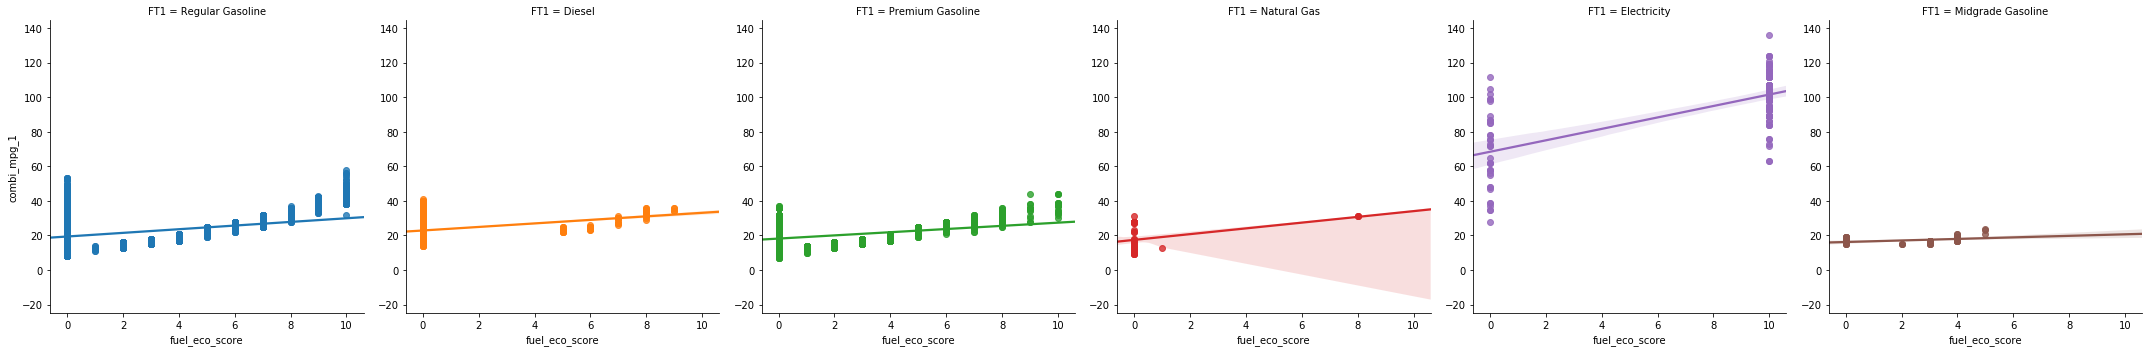

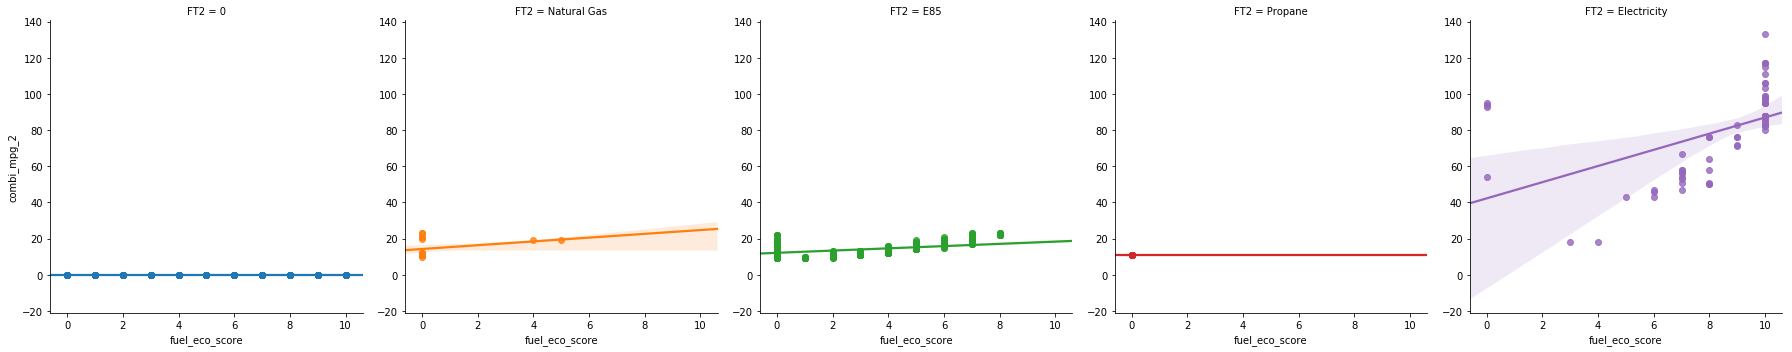

In [27]:
# Fuel Economy Score feels like it could be related to combi_mpg - but graph below suggests rather weak correlation
# Tested also for city and hw_mpg --- looks very much the same
# Note: There are clusters visible by fuel_eco_score and FT1 and FT2 respectively -explore later
sns.lmplot(x='fuel_eco_score', y='combi_mpg_1', data=fuel_economy,
          col='FT1', hue='FT1');
sns.lmplot(x='fuel_eco_score', y='combi_mpg_2', data=fuel_economy,
          col='FT2', hue='FT2');

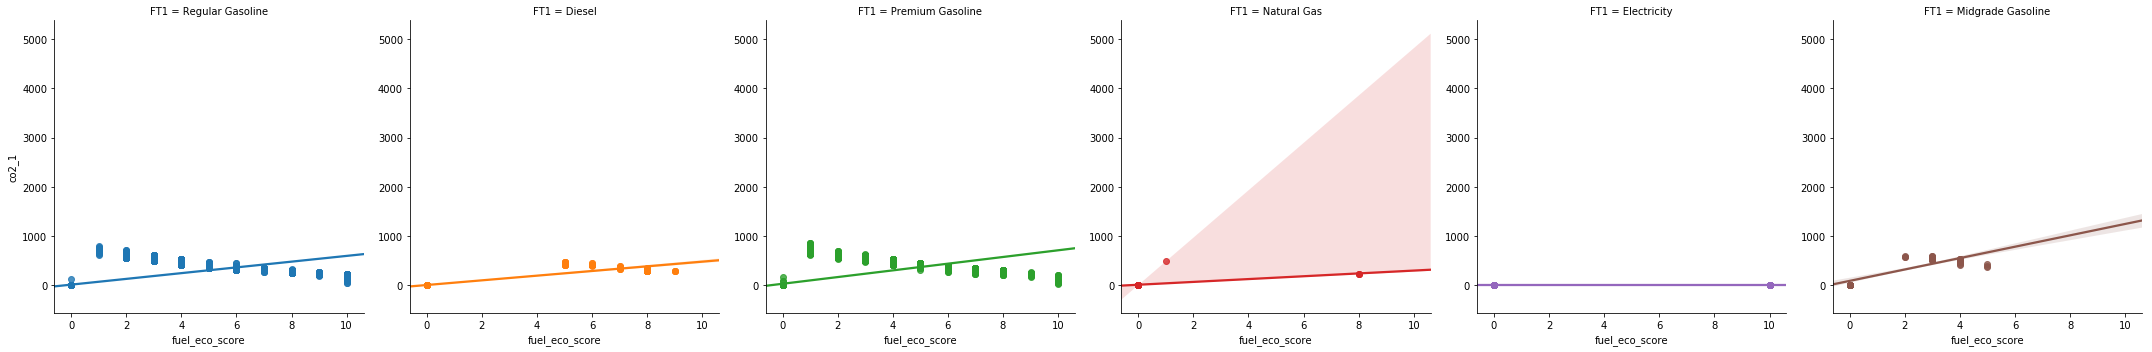

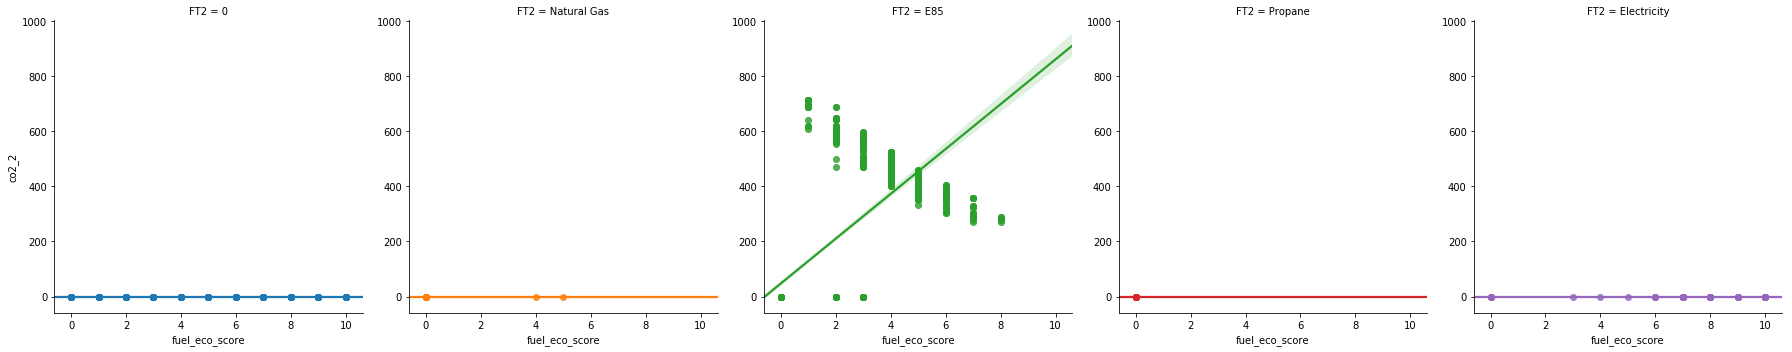

In [28]:
# Similar consideration for fuel_eco_score and tailpipe CO2
# Note: tailpipe CO2 is available by EPA test from 2013 onwards; prior years have been estimated
sns.lmplot(x='fuel_eco_score', y='co2_1', data=fuel_economy,
          col='FT1', hue='FT1');
sns.lmplot(x='fuel_eco_score', y='co2_2', data=fuel_economy,
          col='FT2', hue='FT2');

In [29]:
# Correlation calculation shows that fuel_eco_score is more closely affiliated with ghg_score than with any _mpg_
fuel_economy.loc[:,['fuel_eco_score', 'ghg_score','ghg_score_alt', 'co2_1', 'co2_2',
                    'combi_mpg_1', 'combi_mpg_2', 'city_mpg_1', 'city_mpg_2', 'hw_mpg_1', 'hw_mpg_2']].corr()

,fuel_eco_score,ghg_score,ghg_score_alt,co2_1,co2_2,combi_mpg_1,combi_mpg_2,city_mpg_1,city_mpg_2,hw_mpg_1,hw_mpg_2
fuel_eco_score,1.000000,0.999594,0.201026,0.788997,0.163051,0.409566,0.171410,0.390950,0.171394,0.421639,0.169156
ghg_score,0.999594,1.000000,0.201183,0.788533,0.163185,0.409089,0.177212,0.390670,0.177133,0.420912,0.174914
ghg_score_alt,0.201026,0.201183,1.000000,0.287103,0.871094,0.000948,0.383632,-0.006303,0.338156,0.014675,0.441530
co2_1,0.788997,0.788533,0.287103,1.000000,0.321045,0.078725,0.106364,0.055829,0.095769,0.115697,0.119414
co2_2,0.163051,0.163185,0.871094,0.321045,1.000000,-0.030027,0.348152,-0.032504,0.307680,-0.022362,0.399861
combi_mpg_1,0.409566,0.409089,0.000948,0.078725,-0.030027,1.000000,0.045121,0.988213,0.051881,0.972357,0.035242
combi_mpg_2,0.171410,0.177212,0.383632,0.106364,0.348152,0.045121,1.000000,0.051975,0.995380,0.035210,0.991692
city_mpg_1,0.390950,0.390670,-0.006303,0.055829,-0.032504,0.988213,0.051975,1.000000,0.059762,0.931739,0.040567
city_mpg_2,0.171394,0.177133,0.338156,0.095769,0.307680,0.051881,0.995380,0.059762,1.000000,0.039757,0.975392
hw_mpg_1,0.421639,0.420912,0.014675,0.115697,-0.022362,0.972357,0.035210,0.931739,0.039757,1.000000,0.028627


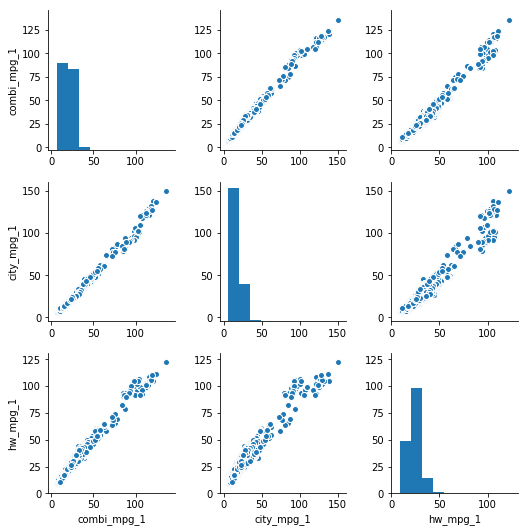

In [30]:
# Note: all the _mpg_ values are closely correlated
# I think I read somewhere in EPA description that combi assumed 55% city and 45% highway(hw) and is used for calc. of annual cost
# If I want to use the city, highway MPG separately later on, I might need the columns -- decide to leave them in

sns.pairplot(fuel_economy, vars=['combi_mpg_1', 'city_mpg_1', 'hw_mpg_1']);

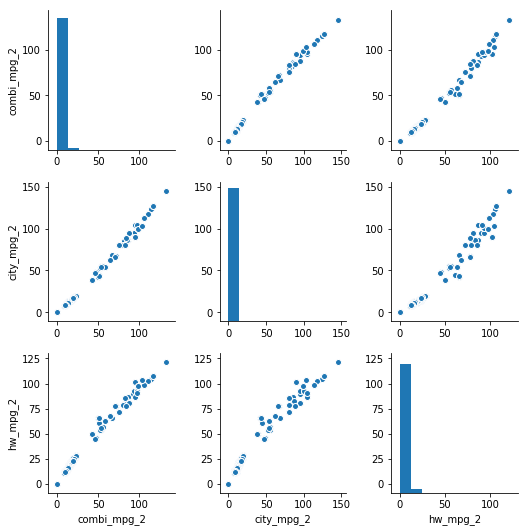

In [31]:
sns.pairplot(fuel_economy, vars=['combi_mpg_2','city_mpg_2','hw_mpg_2']);

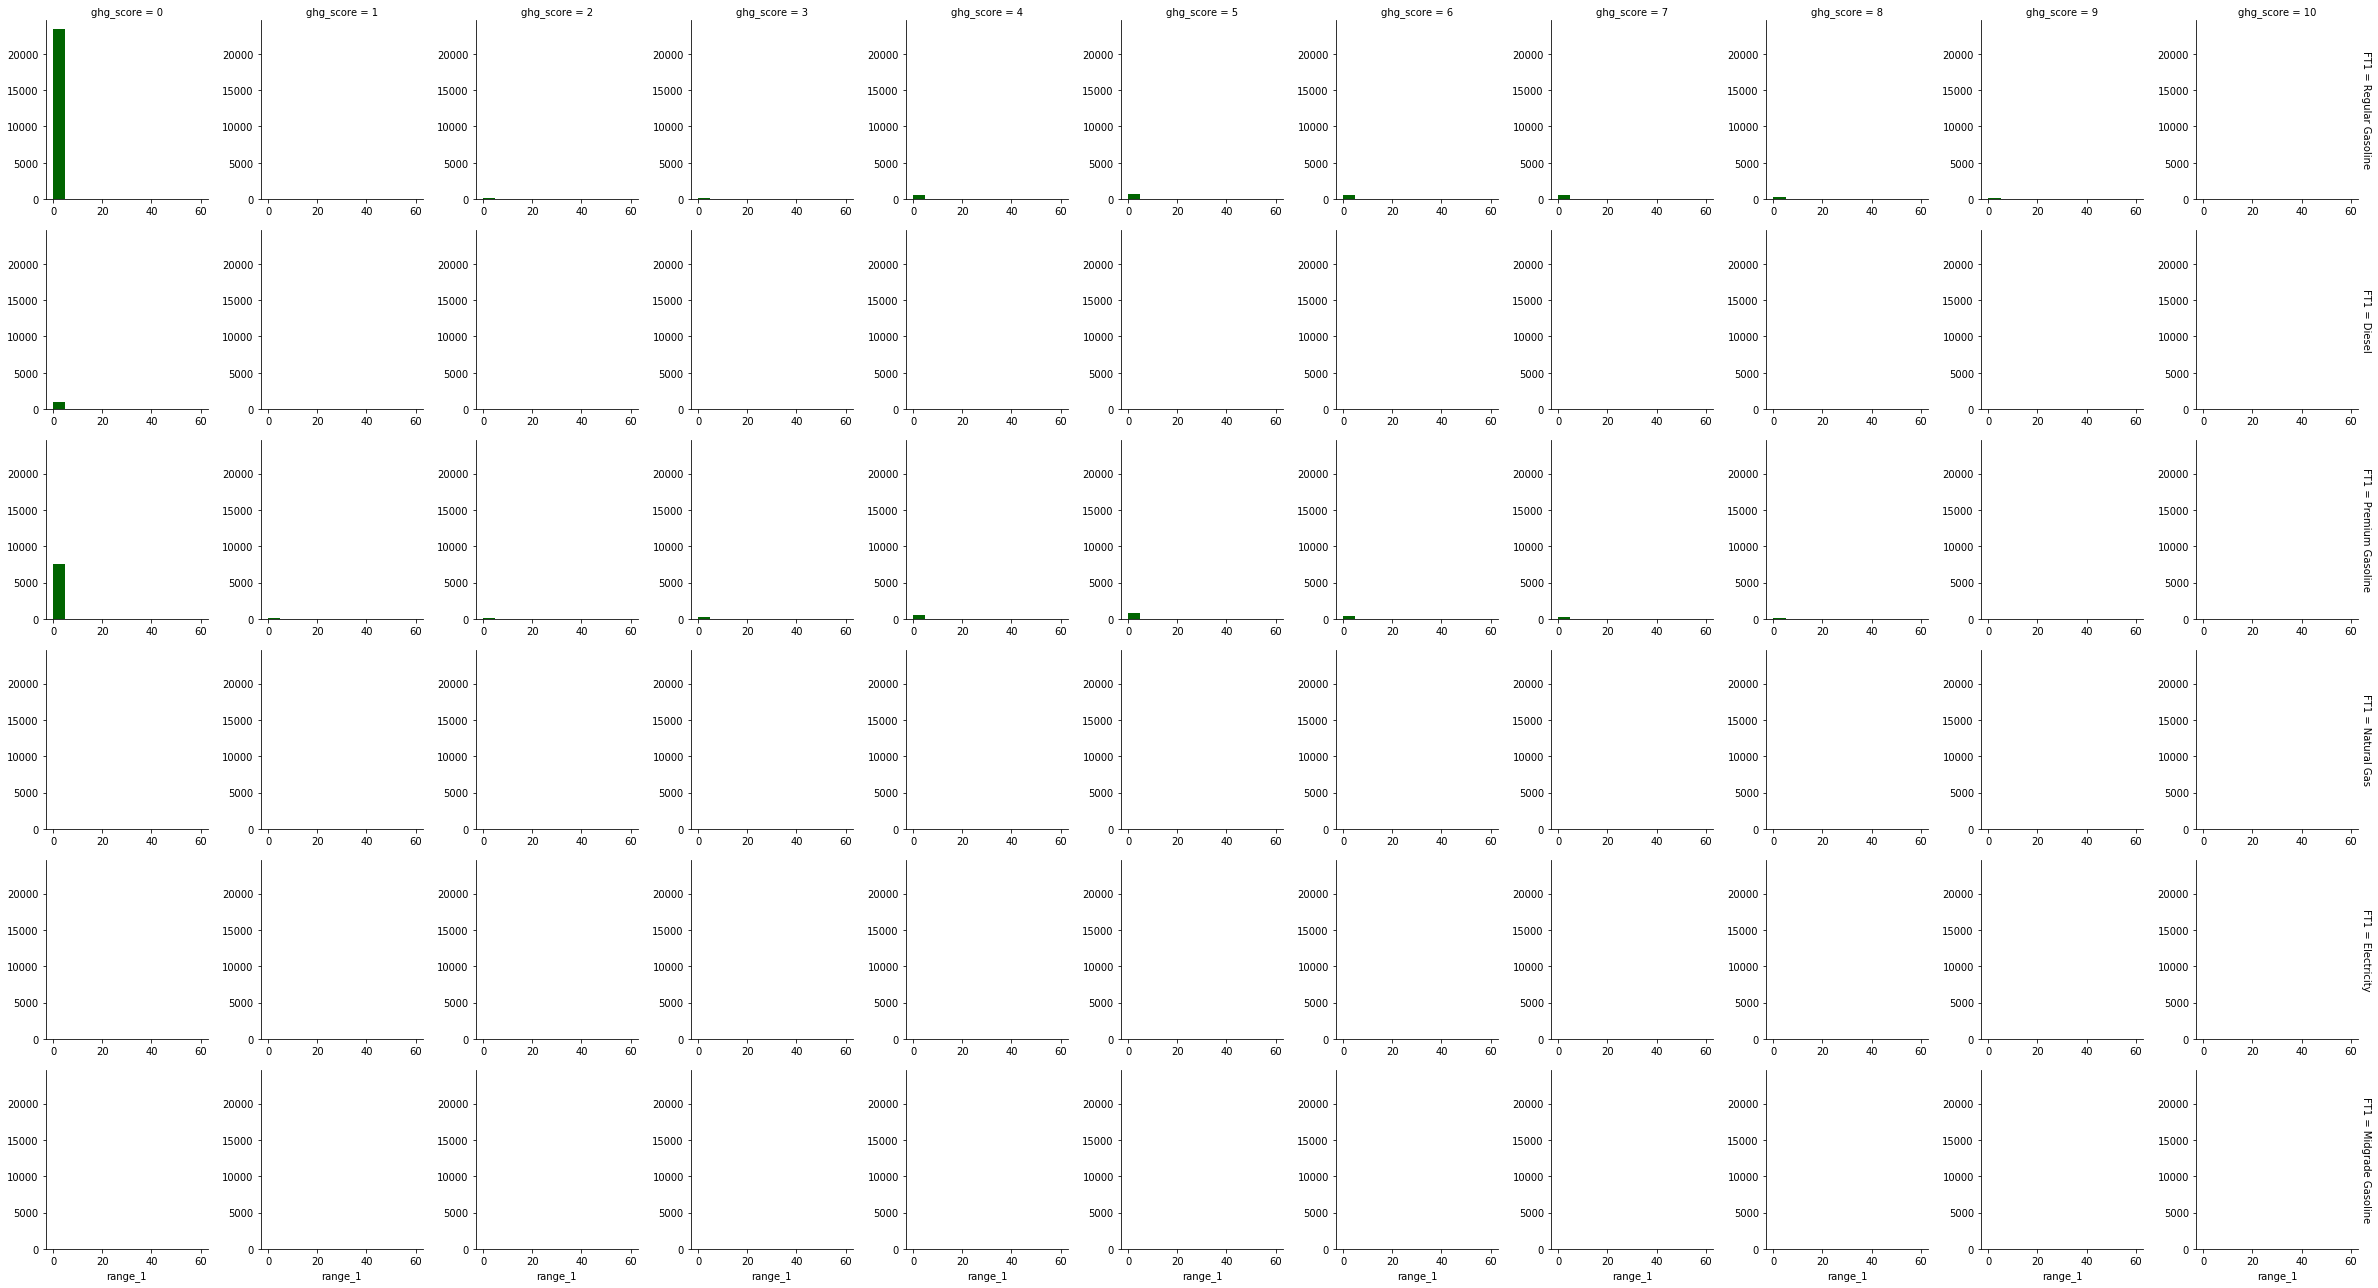

In [32]:
# Range (FT1) has ~37,980 empty rows too and Range (FT2) has ~36,680 empty rows - explore
# seems that ranges are mostly available for 'regular gasoline' with ghg scores from 0 to ~9; and premium gasoline; a bit diesel
# ranges feel a bit 'useless' as of right now; checking correlation (below) and dropping if not related to fuel_score or cost
g = sns.FacetGrid(fuel_economy,row='FT1', col='ghg_score',margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "range_1", color='darkgreen', bins=bins, lw=0);

In [33]:
fuel_economy.loc[:,['cost_1', 'cost_2', 'ghg_score','ghg_score_alt', 'co2_1', 'co2_2',
                    'range_1', 'range_2']].corr()

,cost_1,cost_2,ghg_score,ghg_score_alt,co2_1,co2_2,range_1
cost_1,1.000000,0.069812,-0.276646,-0.023047,-0.049475,0.016047,-0.116454
cost_2,0.069812,1.000000,0.050523,0.504841,0.143753,0.561445,-0.009554
ghg_score,-0.276646,0.050523,1.000000,0.201183,0.788533,0.163185,0.185075
ghg_score_alt,-0.023047,0.504841,0.201183,1.000000,0.287103,0.871094,-0.005739
co2_1,-0.049475,0.143753,0.788533,0.287103,1.000000,0.321045,-0.020677
co2_2,0.016047,0.561445,0.163185,0.871094,0.321045,1.000000,-0.005736
range_1,-0.116454,-0.009554,0.185075,-0.005739,-0.020677,-0.005736,1.000000


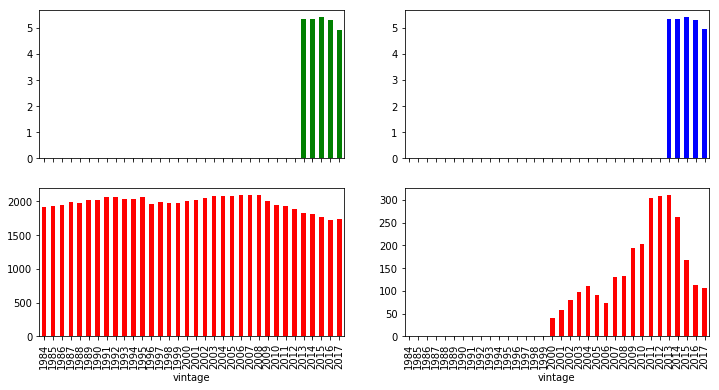

In [47]:
# Looking at target variables fuel_eco_score and ghg_score and cost_1 and cost_2 per vintage(year)
# We have fuel_eco_score and ghg_score only from 2013 onwards (=5 years worth of data points) > need to carve out that dataset
# cost for FT1 (conventional fuels) are relatively stable year over year; the alternative FT2 cost are lower...
#... but have a funny spike in 2011-2013 period and then taper off again --- what was going on then?
fig, axs = plt.subplots(2,2, sharex=True, sharey=False)
g = fuel_economy.groupby('vintage')['fuel_eco_score'].mean()
h = fuel_economy.groupby('vintage')['ghg_score'].mean()
i = fuel_economy.groupby('vintage')['cost_1'].mean()
j = fuel_economy.groupby('vintage')['cost_2'].mean()
g.plot(kind='bar', color='green',ax=axs[0,0], figsize=(12,6));
h.plot(kind='bar', color='blue', ax=axs[0,1], figsize=(12,6));
i.plot(kind='bar', color='red', ax=axs[1,0], figsize=(12,6));
j.plot(kind='bar', color='red', ax=axs[1,1], figsize=(12,6));

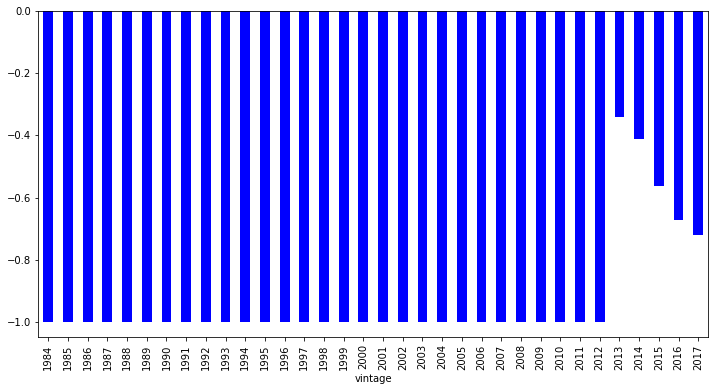

In [48]:
# checking out the funny alternative score --- it is a negative value --- years 1984 to 2012: negative -1: means n/a
# decide to drop that from data set.
k = fuel_economy.groupby('vintage')['ghg_score_alt'].mean()
k.plot(kind='bar', color='blue', figsize=(12,6));

In [49]:
fuel_economy.drop('ghg_score_alt', axis=1, inplace=True)

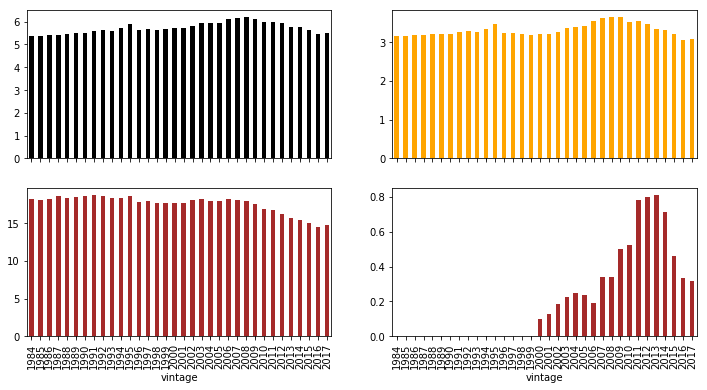

In [54]:
# Looking at a few car characteristics over time as well to get a better feeling on how technical details changed
# relatively stable average number of cylinders and displacement (in liters) (running with "mean") - slight dip in recent years
# larger dip in barrels for FT1
# There is an exact correlation between barrels_per FT and cost_per FT (see chart above)
fig, axs = plt.subplots(2,2, sharex=True, sharey=False, figsize=(12,6))
l = fuel_economy.groupby('vintage')['num_cylinder'].mean()
m = fuel_economy.groupby('vintage')['engine_displace'].mean()
n = fuel_economy.groupby('vintage')['barrels_1'].mean()
o = fuel_economy.groupby('vintage')['barrels_2'].mean()
l.plot(kind='bar', color='black',ax=axs[0,0]);
m.plot(kind='bar', color='orange', ax=axs[0,1]);
n.plot(kind='bar', color='brown', ax=axs[1,0]);
o.plot(kind='bar', color='brown', ax=axs[1,1]);

In [56]:
# start_stop technology information is either not available (0) or N(0) or Y(1) --- need to reframe categorical to enable analysis
# existence of start_stop technology should be negatively correlated to consumption (barrels) and hence cost for FT1
fuel_economy.loc[:,'start_stop'].value_counts()

0    31670
N     4677
Y     1766
Name: start_stop, dtype: int64

In [60]:
# there are 34 different types of classes in the data set --- it might be worth bundling and comparing them with respect to their
# cost_1 (for FT1) and cost_2 (for FT2) and their fuel_eco_score and ghg_score
fuel_economy.loc[:,'class'].value_counts()

Compact Cars                          5508
Subcompact Cars                       4872
Midsize Cars                          4395
Standard Pickup Trucks                2354
Sport Utility Vehicle - 4WD           2082
Large Cars                            1891
Two Seaters                           1886
Sport Utility Vehicle - 2WD           1627
Small Station Wagons                  1499
Special Purpose Vehicles              1455
Minicompact Cars                      1260
Standard Pickup Trucks 2WD            1177
Vans                                  1141
Standard Pickup Trucks 4WD             986
Midsize-Large Station Wagons           656
Special Purpose Vehicle 2WD            613
Small Pickup Trucks                    538
Small Sport Utility Vehicle 4WD        526
Midsize Station Wagons                 523
Vans, Cargo Type                       438
Small Pickup Trucks 2WD                436
Standard Sport Utility Vehicle 4WD     434
Small Sport Utility Vehicle 2WD        403
Minivan - 2

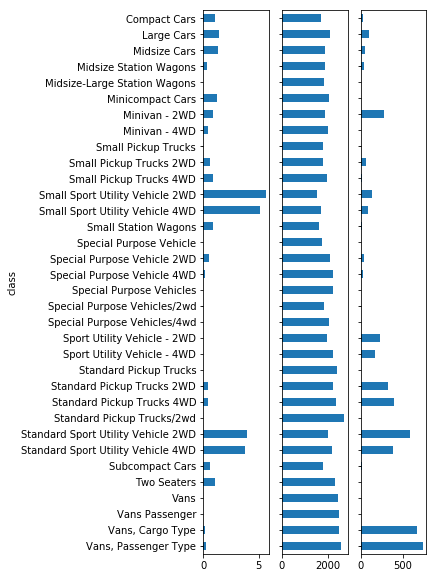

In [75]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(4,10))
a = fuel_economy.groupby('class')['fuel_eco_score'].mean().sort_index(ascending=False)
b = fuel_economy.groupby('class')['cost_1'].mean().sort_index(ascending=False)
c = fuel_economy.groupby('class')['cost_2'].mean().sort_index(ascending=False)
a.plot(kind='barh', ax=axs[0]);
b.plot(kind='barh', ax=axs[1]);
c.plot(kind='barh', ax=axs[2]);

In [35]:
# note: in the column 'make' I saw a few combination from car company and model name --- need to clean up a bit more!!!

# Next steps

1. Fuel_eco_score and ghg_score data is only available for the last 5 years --- need to carve out these vintage years to analyze them separately
    > the graphs on fuel type (FT1 and FT2) showed some interesting spread for fuel_eco_scores that can be explored
2. Turn a few categorical values into numerical values (get_dummies or similar) --- guzzler tax and start_stop technology
3. Package and combine a few categories with multiple entries --- car class, drive (2W, 4W with all, front, rear), chargers, ...
4. Revisit to what extent split of mpg into city and highway is helpful (vs. combination)
5. Revisit whether the passenger and luggage volumes are  going to be relevant and how to interpret these (excl. for now, because did not fully understand measurement and relevance --- it's in cubic feet (not weight)
<br>
<br>**Overall** Start digging into fuel-cost drivers for FT1 and FT2 (separately) and see what car parameters (number of cylinders, wheel drive, chargers etc.) are driving factors for cost: Linear, Logistic Regressions and Decisions Trees to predict cost for any type ('class')
<br>**Overall** On the fuel_eco_score and ghg_score subset (vintages 2013-2017): ditto look at these parameters .
<br>**Bonus** Forecast the overall emitted CO2 volume of a representative set of cars and attribute it to city traffic (55%) and predict how this will evolve with the mix of cars over time!